In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the training dataset
block_size = 3 #context window
X,Y = [],[]

for w in words[:5]:
    print(w)
    context = [0] * block_size
    
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
# C is the embedding look up table
C = torch.randn((27, 2))

In [12]:
emb = C[X] # emb is the embedded X
emb.shape

torch.Size([32, 3, 2])

In [13]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [14]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [16]:
h.shape

torch.Size([32, 100])

In [17]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [23]:
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

In [26]:
probs[0].sum()

tensor(1.0000)

In [29]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [31]:
probs[torch.arange(32), Y].shape

torch.Size([32])

In [28]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(11.6238)

In [ ]:
# benefits of cross entropy
# 1. forward pass and backward pass are much more efficient
# 2. things can be much more numerically well behaved

In [ ]:
# ---full code---

In [4]:
block_size = 4 # context window
embedding_dim = 20

In [5]:
# define the function to convert words to datasets
def build_dataset(words):
    X,Y = [],[]

    for w in words:
        # print(w)
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    
    return X, Y

In [6]:
# build training (80%), dev (10%), test (10%) sets
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [7]:
# initialize parameters
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, embedding_dim), generator=g)
W1 = torch.randn((block_size * embedding_dim, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [73]:
sum(p.nelement() for p in parameters) # number of parameters in total

22167

In [74]:
for p in parameters:
    p.requires_grad = True

In [75]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [76]:
lri = []
lossi = []
stepi = []

In [81]:
# training

for i in range(200000):
    
    # construct mini batch
    ix = torch.randint(0, X_train.shape[0], (64,))
    
    # forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    #lr = 0.1 if i < 100000 else 0.01
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.1378486156463623


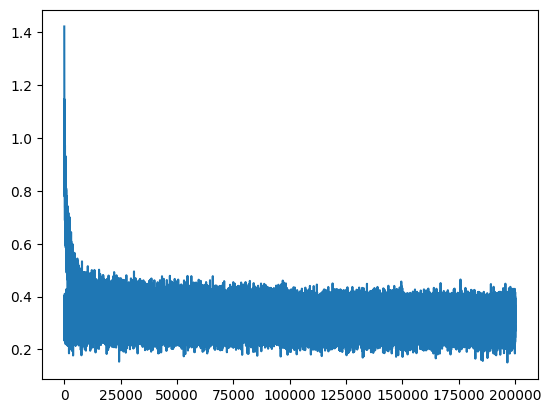

In [83]:
plt.plot(stepi, lossi)

In [84]:
# loss on training set
emb = C[X_train] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.0604, grad_fn=<NllLossBackward>)

In [85]:
# loss on dev set
emb = C[X_dev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1303, grad_fn=<NllLossBackward>)